# TIME SERIES FORECASTING

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

#Importing Forecasting Tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose ## for ETS Plots
from pmdarima import auto_arima   # for determining ARIMA orders


import warnings
warnings.filterwarnings("ignore")



In [2]:
#Load dataset
df = pd.read_csv('../Data/co2_mm_mlo.csv')

In [3]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [4]:
df['date'] = pd.to_datetime(dict(year=df['year'],month=df['month'],day=1))

In [5]:
#Set 'date' to be the index
df.set_index('date',inplace=True)
df.index.freq='MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


## Plot the data

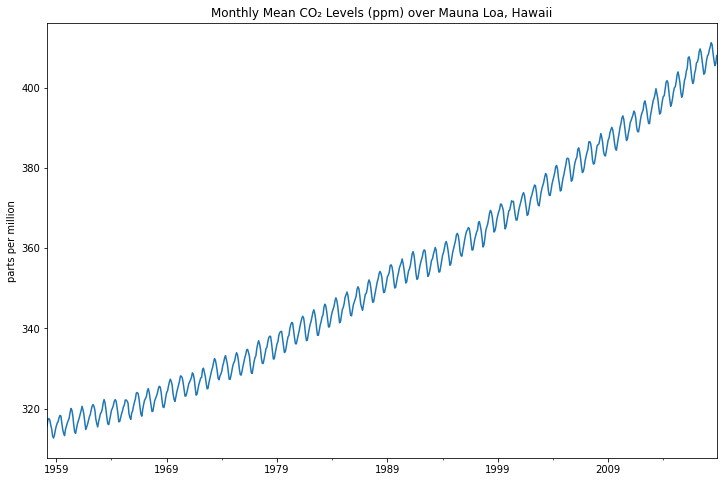

In [25]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(figsize=(12,8),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);


## Run an ETS Decomposition

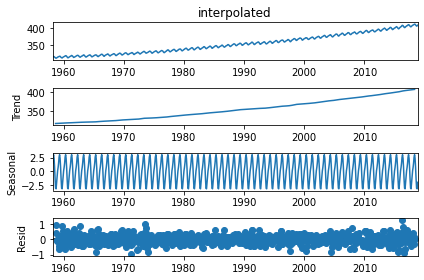

In [20]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();


There seems to be an annual seasonality, though small in scale compared to overall values 

### Run pmdarima.auto_arima to obtain recommendedmodels

In [12]:
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.309
Date:                            Mon, 12 Oct 2020   AIC                            424.618
Time:                                    17:22:44   BIC                            452.160
Sample:                                         0   HQIC                           435.245
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3597      0.114      3.152      0.002       0.136       0.583
ar.L2          0.0844      0.059      1.440      0.150      -0.030       0.199
ma.L1         -0.7099      0.109     -6.525      0.000      -0.923      -0.497
ar.S.L12       0.9996      0.000   2747.123      0.000       0.999       1.000
ma.S.L12      -0.8637      0.022    -39.989      0.000      -0.906      -0.821
sigma2         0.0956      0.005     20.449      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       43.75   Jarque-Bera (JB):                 4.36
Prob(Q):                              0.32   Prob(JB):                         0.11
Heteroskedasticity (H):               1.12   Skew:                             0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values. 

### Split the data into train and test

In [34]:
len(df)

729

In [14]:
#Set 1 year for testing, rest all to train 
train = df.iloc[:717]
test = df.iloc[717:]

## Fit a SARIMA(2,1,1)(1,0,1,12) Model

In [15]:
model = SARIMAX(train['interpolated'],order=(2,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.890
Date:                            Mon, 12 Oct 2020   AIC                            415.780
Time:                                    17:25:03   BIC                            443.222
Sample:                                03-01-1958   HQIC                           426.377
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3505      0.085      4.119      0.000       0.184       0.517
ar.L2          0.0858      0.051      1.687      0.092      -0.014       0.186
ma.L1         -0.7053      0.080     -8.792      0.000      -0.863      -0.548
ar.S.L12       0.9996      0.000   2655.545      0.000       0.999       1.000
ma.S.L12      -0.8644      0.023    -37.529      0.000      -0.910      -0.819
sigma2         0.0954      0.005     20.276      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       44.15   Jarque-Bera (JB):                 4.61
Prob(Q):                              0.30   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
#Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start,end=end,dynamic=False,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12)Predictions')


In [17]:
#Compare predictions to the expected values
for i in range(len(predictions)):
    print('Predicted={}, Expected={}'.format(predictions[i],test['interpolated'][i]))

Predicted=406.59959599866005, Expected=406.81
Predicted=407.8162802172976, Expected=407.96
Predicted=408.57087139130033, Expected=408.32
Predicted=409.480701559173, Expected=409.41
Predicted=411.0426935546907, Expected=410.24
Predicted=411.6474371805732, Expected=411.24
Predicted=410.866646153863, Expected=410.79
Predicted=409.17567353509526, Expected=408.71
Predicted=407.075622860797, Expected=406.99
Predicted=405.625970524571, Expected=405.51
Predicted=405.89789479454754, Expected=406.0
Predicted=407.4327334741815, Expected=408.02


### Comparing our predictions with the actual values 

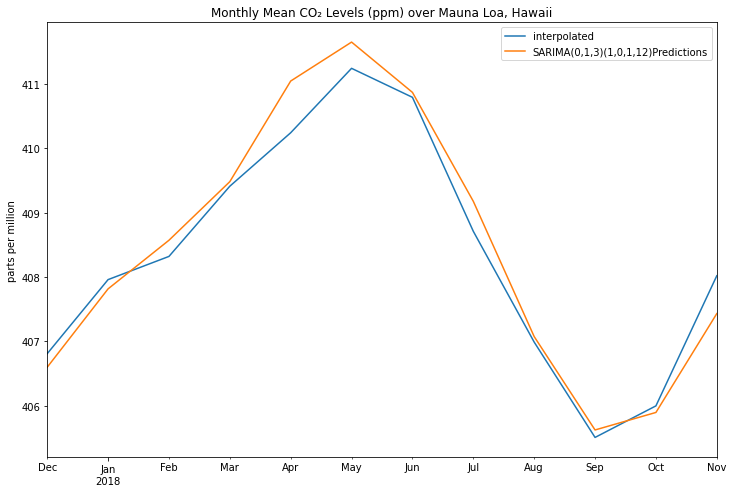

In [19]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''
ax = test['interpolated'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Evaluation of the model

In [27]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['interpolated'],predictions)
print(f'SARIMA(2,1,1)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(2,1,1)(1,0,1,12) MSE Error: 0.1284997284


In [28]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['interpolated'],predictions)
print(f'SARIMA(2,1,1)(1,0,1,12) RMSE Error: {error:11.10}')


SARIMA(2,1,1)(1,0,1,12) RMSE Error: 0.3584685877


### Retrain the model on the full data and forecast the future

In [29]:
model = SARIMAX(df['interpolated'],order=(2,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(2,1,1)(1,0,1,12) Forecast')


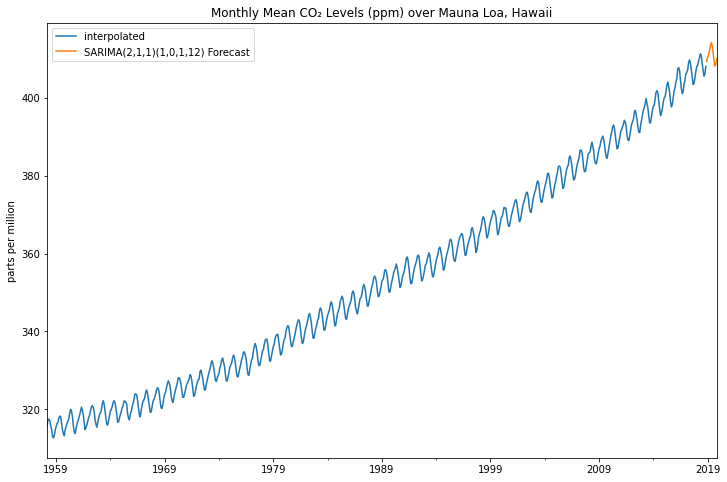

In [30]:
#Plot predictions against kmown values
title = title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''
ax = df['interpolated'].plot(figsize=(12,8),legend=True,title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);